In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [2]:
random_seed = 98

In [3]:
# Function: computing W and d (diagonal entries)

def A_matrix(A_dim=100, W_tilde_mean=0, W_tilde_scale=1, exp_rate=1):
    
    # IID N(W_tilde_mean, W_tilde_scale) entries
    W_tilde = np.random.normal(loc = W_tilde_mean, 
                               scale = W_tilde_scale, 
                               size = (A_dim, A_dim))
    
    # QR decomposition
    Q, R = np.linalg.qr(W_tilde)
    W = Q

    # Diagonal matrix elements (using Exp(lambda))
    exp_scale = 1/exp_rate
    d = np.random.exponential(scale=exp_scale, size=A_dim)
    
    return W, d

In [4]:
# Function: drawing solution vectors x^(i) from prior mu_0 = N(0, A^-1)

def sample_solution_x(W, d):
    
    # Inverse & squareroot of D matrix elements for transforming std. normal samples
    inv_sqrt_d = 1.0 / np.sqrt(d)
    B = W @ np.diag(inv_sqrt_d)
    
    # Std. normal samples
    z = np.random.normal(size=(W.shape[0], 1))
    
    # Transform
    solution_x = B @ z
    
    return solution_x

In [10]:
# Function: Randomised Postiterations (Algorithm 1)

def rand_post_iter(A, b, x0, eps_1, eps_2):
    
    # Initialisation
    k = 0

    r = b - A @ x0
    r_list = [r]
    
    p = r
    p_list = [p]
    
    x = x0
    x_list = [x0]
    
    L = []
    x_solution = None
    
    # Loop to find x* with ||r|| <= eps_1
    while True:
        
        Ap = A @ p
        rTr = r.T @ r
        alpha = (rTr) / (p.T @ Ap)
        
        x_new = x + (alpha * p)
        x_list.append(x_new)

        r_new = r - (alpha * Ap)
        
        beta = (r_new.T @ r_new) / rTr
        
        p_new = r_new + (beta * p)
        
        if x_solution is None and np.linalg.norm(r_new) <= eps_1:
            x_solution = x_new
            print(f"Converged: less than eps_1 at iteration {k}")
        
        if np.linalg.norm(r_new) > eps_2:
            z = np.random.normal(0, 1)
            psi = np.sqrt(alpha * rTr) / z
            L.append(psi*p_new)
            
        else:
            print(f"Converged: less than eps_2 at iteration {k}")
            break
        
        x = x_new
        r = r_new
        p = p_new
        k += 1
    
    L_matrix = np.hstack(L)
    
    return x_solution, L_matrix

In [11]:
#

def sim_based_cal( 
    x0, 
    eps_1, 
    eps_2,
    A_dim = 100, 
    W_tilde_mean = 0, 
    W_tilde_scale = 1, 
    exp_rate = 1,
    n_sim = 1
):
    t = []
    
    # Fixed random vector
    w = np.random.normal(size=A_dim)
    
    # Computing fixed A/W/d for entire experiment
    W, d = A_matrix(A_dim, W_tilde_mean, W_tilde_scale, exp_rate)
    A = W @ np.diag(d) @ W.T
    
    for i in range(n_sim):
        
        # Sampled solution
        x_star = sample_solution_x(W, d)
        b = A @ x_star
        
        x_solution, L = rand_post_iter(A, b, x0, eps_1, eps_2)
        
        numerator = w.T @ (x_solution - x_star)
        print("Numerator = ", numerator)
        denominator = np.sqrt(w.T @ L @ L.T @ w)
        print("Denominator = ", denominator)
        cdf = norm.cdf(numerator/denominator)
        t.append(cdf)
    
    t_vector = np.array(t)
    
    return t_vector

In [12]:
np.random.seed(random_seed)

data_size = 100

t_test = sim_based_cal( 
    x0 = np.zeros((data_size,1)), 
    eps_1 = 1e-3, 
    eps_2 = 0.1 * 1e-6,
    A_dim = data_size, 
    W_tilde_mean = 0, 
    W_tilde_scale = 1, 
    exp_rate = 1,
    n_sim = 10
)

Converged: less than eps_1 at iteration 40
Converged: less than eps_2 at iteration 61
Numerator =  [0.00458077]
Denominator =  24.47013121163122
Converged: less than eps_1 at iteration 34
Converged: less than eps_2 at iteration 61
Numerator =  [0.00336299]
Denominator =  81.72566152162219
Converged: less than eps_1 at iteration 36
Converged: less than eps_2 at iteration 60
Numerator =  [0.00087468]
Denominator =  75.75430843876771
Converged: less than eps_1 at iteration 36
Converged: less than eps_2 at iteration 62
Numerator =  [-0.00286838]
Denominator =  167.4634023617799
Converged: less than eps_1 at iteration 41
Converged: less than eps_2 at iteration 62
Numerator =  [0.00055374]
Denominator =  69.91801182593505
Converged: less than eps_1 at iteration 40
Converged: less than eps_2 at iteration 61
Numerator =  [-0.0051423]
Denominator =  84.1090274411137
Converged: less than eps_1 at iteration 38
Converged: less than eps_2 at iteration 60
Numerator =  [-0.00174716]
Denominator =  11

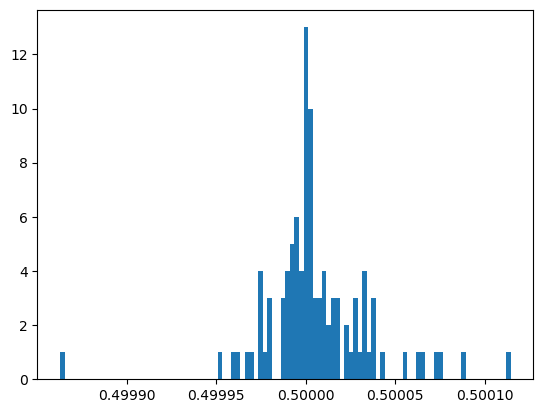

In [8]:
plt.hist(t_test, bins=100);